# Sensitivity

This notebook calculates the sensitivity to the events included in the training data set. Therefore, some random choosen events out of the training file are taken, thereof all time windows (all time windows with the same event index) and added to the coplete noise training data set. The test data set is always the same and includes all event and noise time windows therein. Plotted is the mean balanced accuracy score out of the n_folds with their standard deviation.

In [1]:
import numpy as np
import pandas as pd
import random
from time import perf_counter
from imblearn.ensemble import BalancedRandomForestClassifier # new
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [2]:
# List of attributes we want to use for classification
attribute_names = ['duration', 'RappMaxMean','RappMaxMedian', 'AsDec', 'KurtoSig', \
                    'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber', 'INT1', \
                    'INT2', 'INT_RATIO', 'ES[0]', 'ES[1]', 'ES[2]', 'ES[3]', 'ES[4]', 'KurtoF[0]', \
                    'KurtoF[1]', 'KurtoF[2]', 'KurtoF[3]', 'KurtoF[4]', 'DistDecAmpEnv', \
                    'env_max/duration(Data,sps)', 'MeanFFT', 'MaxFFT', 'FmaxFFT', \
                    'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT', 'VarFFT', 'NpeakFFT', \
                    'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT', 'E4FFT', 'gamma1', 'gamma2', \
                    'gammas', 'SpecKurtoMaxEnv', 'SpecKurtoMedianEnv', 'RATIOENVSPECMAXMEAN', \
                    'RATIOENVSPECMAXMEDIAN', 'DISTMAXMEAN', 'DISTMAXMEDIAN', 'NBRPEAKMAX', \
                    'NBRPEAKMEAN', 'NBRPEAKMEDIAN', 'RATIONBRPEAKMAXMEAN', \
                    'RATIONBRPEAKMAXMED', 'NBRPEAKFREQCENTER', 'NBRPEAKFREQMAX', \
                    'RATIONBRFREQPEAKS', 'DISTQ2Q1', 'DISTQ3Q2', 'DISTQ3Q1']

In [3]:
# Read train and test feautre file
#catalog = pd.read_csv('../feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder.csv')
catalog = pd.read_csv('../feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder_without_bigsf.csv')
catalog_test = pd.read_csv('../feature_files/test_features_yfilt_40s_hSNR_v4_with_thunder.csv')

def combine_classes_catalog_2(cat):
    cat.loc[cat['event_class'] == 2, 'event_class'] = 0 # Earthqauke Illgraben to Noise
    return cat

catalog = combine_classes_catalog_2(catalog)
catalog_test = combine_classes_catalog_2(catalog_test)

# take all attributes
X_train = np.asarray(catalog[attribute_names])
y_train = np.asarray(catalog['event_class'])
X_test = np.asarray(catalog_test[attribute_names])
y_test = np.asarray(catalog_test['event_class'])

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

#print(len(catalog['event_class']==1))
#print(np.where(catalog['event_class']==1))
#print(np.shape(np.where(y_test==1)))
#print(np.shape(np.where(y_train==1)))

(620, 58)
(620,)
(263, 58)
(263,)


In [12]:
ev_catalog = catalog[catalog['event_class']!=0] # df includes all event timewindows
noise_catalog = catalog[catalog['event_class']==0] # df indludes all noise timewindows
np.unique(ev_catalog['event_idx']).shape[0]

27

In [13]:
clf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                     n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                     oob_score=False, bootstrap=True, class_weight=None,random_state=10)

In [14]:
cvi = 0 # initialise counter
n_ev_min = 1 # min number of events in training data set
n_ev_max = 27+1 # max number of events in training data set
n_folds = 5

# initialisieren
best_acc = np.zeros((n_ev_max,n_folds))
best_bal_acc = np.zeros((n_ev_max,n_folds))
best_con_matrix = {}
best_probab = {}
best_params = {}

In [15]:
#training set 
for ne in range(n_ev_min, n_ev_max): # Anzahl events die genommen werden (später auf x achse)
    for n_ci in range(n_folds): # anzahl der verschiedennen möglichkeitnen cross-folds validations -> variation
        subset = random.sample(list(np.unique(ev_catalog['event_idx'])), ne) # sequence liste mit indeces von events
        print(subset)
        
        df_ev_append = ev_catalog[ev_catalog['event_idx'].isin(subset)] # eppend all timewindows of selected events to new df
        df_new = pd.concat([noise_catalog, df_ev_append]) # merge event and noiese df
        X_new = np.asarray(df_new[attribute_names])
        y_new = np.asarray(df_new['event_class'])
        
        # Fit model
        t1_start = perf_counter()
        clf.fit(X_new, y_new)
        t1_stop = perf_counter()
        print('Elapsed time seconds: %.3f ' % (t1_stop - t1_start))
        
        # Predict test data set
        y_pred = clf.predict(X_test) 
        
        print('Balanced accuracy: %.3f' % balanced_accuracy_score(y_test,y_pred))
    
        #store all scores
        best_acc[ne,n_ci]=accuracy_score(y_test, y_pred)
        best_bal_acc[ne,n_ci]=balanced_accuracy_score(y_test,y_pred)
        #best_probab[cvi]=clf.predict_proba(X_test)
        best_con_matrix[cvi]=confusion_matrix(y_test, y_pred)
        best_params[cvi] = subset
        
        cvi += 1

[23]
Elapsed time seconds: 7.801 
Balanced accuracy: 0.500
[18]
Elapsed time seconds: 17.556 
Balanced accuracy: 0.500
[125]
Elapsed time seconds: 6.990 
Balanced accuracy: 0.500
[155]
Elapsed time seconds: 8.838 
Balanced accuracy: 0.500
[68]
Elapsed time seconds: 5.672 
Balanced accuracy: 0.500
[97, 73]
Elapsed time seconds: 8.605 
Balanced accuracy: 0.500
[22, 155]
Elapsed time seconds: 6.269 
Balanced accuracy: 0.500
[53, 74]
Elapsed time seconds: 5.798 
Balanced accuracy: 0.500
[67, 63]
Elapsed time seconds: 12.657 
Balanced accuracy: 0.500
[62, 30]
Elapsed time seconds: 9.995 
Balanced accuracy: 0.500
[125, 50, 94]
Elapsed time seconds: 7.089 
Balanced accuracy: 0.500
[67, 22, 74]
Elapsed time seconds: 11.625 
Balanced accuracy: 0.500
[68, 28, 157]
Elapsed time seconds: 12.089 
Balanced accuracy: 0.500
[19, 62, 157]
Elapsed time seconds: 15.984 
Balanced accuracy: 0.500
[155, 30, 28]
Elapsed time seconds: 13.358 
Balanced accuracy: 0.500
[93, 18, 19, 94]
Elapsed time seconds: 10.

Elapsed time seconds: 7.105 
Balanced accuracy: 0.905
[97, 63, 89, 155, 28, 31, 68, 53, 62, 94, 18, 73, 22, 19, 93, 32, 51, 67]
Elapsed time seconds: 9.154 
Balanced accuracy: 0.891
[63, 18, 53, 93, 156, 94, 32, 97, 21, 23, 67, 22, 62, 73, 89, 125, 31, 51]
Elapsed time seconds: 11.252 
Balanced accuracy: 0.882
[68, 93, 73, 18, 94, 63, 74, 21, 45, 157, 50, 28, 67, 89, 19, 156, 125, 22, 155]
Elapsed time seconds: 8.585 
Balanced accuracy: 0.917
[31, 22, 19, 68, 74, 155, 93, 67, 32, 62, 156, 18, 53, 28, 21, 125, 63, 94, 45]
Elapsed time seconds: 13.757 
Balanced accuracy: 0.889
[93, 74, 18, 97, 53, 51, 63, 62, 68, 28, 156, 30, 45, 23, 19, 157, 67, 155, 73]
Elapsed time seconds: 8.616 
Balanced accuracy: 0.896
[157, 21, 63, 45, 31, 23, 93, 73, 89, 28, 30, 19, 32, 156, 97, 53, 18, 74, 22]
Elapsed time seconds: 6.728 
Balanced accuracy: 0.927
[155, 93, 32, 63, 94, 156, 30, 51, 28, 53, 50, 45, 67, 68, 62, 31, 125, 22, 19]
Elapsed time seconds: 6.032 
Balanced accuracy: 0.889
[21, 23, 73, 63, 

In [16]:
best_bal_acc

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.84321653, 0.83845463, 0.85026954, 0.5       , 0.82672956],
       [0.8074124 , 0.84613657, 0.5       , 0.73054807, 0.70435759],
       [0.84303684, 0.8146451 , 0.83607367, 0.82398922, 0.82893082],
       [0.85759209, 0.82884097, 0.84101527, 0.80979335, 0.83881402],
       [0.83863432, 0.80521114, 0.78854447, 0.85512129, 0.84806828],
       [0.83845463, 0.87416891, 0.87672956, 0.84797844, 0.86455526],
       [0.87169811, 0.82884097, 0.8671159 , 0.85732255, 0.86491465],
       [0.88598383, 0.87178796, 0.86756514, 0.8720575 , 0.88607367],
       [0.87187781, 0.89806828, 0.87875112, 0.92416891, 0.89083558],
       [0.88387242, 0.86253369, 0.91226415, 0.9098832 , 0.91940701],
       [0.87663971, 0.91684636, 0.

In [ ]:
#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.dates as md

# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (6.4*2, 4.8) # if wider plot, only change first value.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
#plt.rcParams['ytick.major.pad']= 2

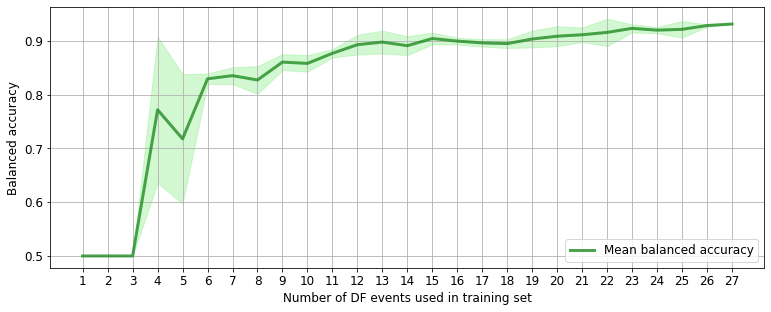

In [28]:
mean_ba = np.mean(best_bal_acc[1::,:],axis=1)

std_ba = np.std(best_bal_acc[1::,:], axis=1)
tprs_upper = np.minimum(mean_ba + std_ba, 1)
tprs_lower = np.maximum(mean_ba - std_ba, 0)

fig, ax = plt.subplots()

ax.fill_between(np.arange(n_ev_min,n_ev_max), tprs_lower, tprs_upper, color='lightgreen', alpha=.4)
ax.plot(np.arange(n_ev_min,n_ev_max), mean_ba,color='forestgreen',
        label='Mean balanced accuracy',
        lw=3, alpha=.8)

#ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', alpha=.8)

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="Receiver operating characteristic example")

plt.xticks(np.arange(n_ev_min,n_ev_max))
ax.legend(loc="lower right")
plt.xlabel('Number of DF events used in training set')
plt.ylabel('Balanced accuracy')
plt.grid()
#plt.show()
#plt.savefig(f'../plot/sensitivity/6.png', bbox_inches='tight', dpi=300)

### code sniplets I do not use any more

In [29]:
gr_train = catalog.groupby('event_idx').first() # takes only first timewindow from event
gr_test = catalog_test.groupby('event_idx').first() # takes only first timewindow from event

Xgr_train = np.asarray(gr_train[attribute_names])
ygr_train = np.asarray(gr_train['event_class'])
Xgr_test = np.asarray(gr_test[attribute_names])
ygr_test = np.asarray(gr_test['event_class'])

In [4]:
# include the whole trainings data set
y_train_mask = y_train.astype(np.bool) # convert integer to boolean 0 -> False, 1 -> True
X_train_ev = X_train[y_train_mask,:][:,:] # apply mask on X_train row wise to extract events
print(X_train_ev.shape, y_train.sum())
X_train_noise = X_train[np.invert(y_train_mask),:][:,:] # apply mask on X_train row wise to extract noise
print(X_train_noise.shape, X_train.shape[0]-y_train.sum())

#df_X_train_ev = pd.DataFrame(X_train_noise)
#df_X_train_noise = pd.DataFrame(X_train_ev)

y_noise = np.zeros(len(X_train_noise))

(82, 58) 82
(538, 58) 538


In [30]:
# includes only the first time window of an event
ygr_train_mask = ygr_train.astype(np.bool) # convert integer to boolean 0 -> False, 1 -> True
Xgr_train_ev = Xgr_train[ygr_train_mask,:][:,:] # apply mask on X_train row wise to extract events
print(Xgr_train_ev.shape, ygr_train.sum())
Xgr_train_noise = Xgr_train[np.invert(ygr_train_mask),:][:,:] # apply mask on X_train row wise to extract noise
print(Xgr_train_noise.shape, Xgr_train.shape[0]-ygr_train.sum())

#df_X_train_ev = pd.DataFrame(X_train_noise)
#df_X_train_noise = pd.DataFrame(X_train_ev)

(27, 58) 27
(256, 58) 256


In [ ]:
ev_catalog = catalog[catalog['event_class']!=0] # df includes all event timewindows
noise_catalog = catalog[catalog['event_class']==0] # df indludes all noise timewindows

#ev_catalog['count'] = range(len(ev_catalog)) # continuous indices
#ev_catalog.set_index(ev_catalog['count'],inplace=True) #replace indices by continzous

#first_ev_catalog = ev_catalog[ev_catalog['slice_idx']==0]
#idx_list = first_ev_catalog.index.to_list()
#print(idx_list)
#print(len(ev_catalog),len(first_ev_catalog))
#first_ev_catalog

In [ ]:
n_events_train=np.arange(1,np.unique(ev_catalog['event_idx']).shape[0]+1)

# Tests

- write a file with all possible combinations
- k-fold cross validation

In [11]:
import numpy as np
import pandas as pd
import csv
import os
import sys
import random
from itertools import combinations
from time import perf_counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier # new
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LinearRegression #new
from sklearn.model_selection import KFold #new
from sklearn.model_selection import cross_val_score #new
from sklearn.model_selection import train_test_split

In [ ]:
accumulator = list()
subset = [1,2,3,4,5] # or whatever
my_list = range(1,11)
for k in [7]:
    for combination in combinations(my_list,k):
        accumulator.append(combination)
        if all(el in combination for el in subset):
            break
accumulator

create and save file with all combinations

In [ ]:
sample_list = range(0,X_train_ev.shape[0])[:20]
#sample_lsit = sample_list[:20]
combinations_list = []

if os.path.exists('../combinations_list.csv'):
    os.remove('../combinations_list.csv')
f = open('../combinations_list.csv', "a+")

for n in range(1,len(sample_list)+1):
    print(n)
    comb = list(combinations(sample_list,n))
#    with open(f'../combinations_list.csv', "a+") as f:
    
    write = csv.writer(f)
    write.writerows(comb)
f.close()

In [ ]:
sample_list = range(0,X_train_ev.shape[0])[:20]
#sample_lsit = sample_list[:20]
combinations_list = []

if os.path.exists('../combinations_list.csv'):
    os.remove('../combinations_list.csv')

f = open('../combinations_list.csv', "a+")

for n in range(1,6):
    print(n)
    comb = list(combinations(sample_list,n))
#    with open(f'../combinations_list.csv', "a+") as f:
    print(comb)
    write = csv.writer(f)
    write.writerows(comb)
f.close()

open txt

In [10]:
with open(f'../combinations_list.csv', "r") as f:
    reader = csv.reader(f)
    list_rows = list(reader)
    test_list = [int(ent) for row in list_rows for ent in row]
print(test_list)

list_rows

print(len(list_rows))
type(list_rows[30][0])

NameError: name 'csv' is not defined

In [ ]:
with open(f'../combinations_list.csv', 'r') as read_obj: # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj) # Get all rows of csv from csv_reader object as list of tuples
    list_of_tuples = list(map(tuple, csv_reader)) # display all rows of csv
list_of_tuples[19:25]

list_of_tuples[-30:-25]

X_new.shape

len(y_new)

In [ ]:
bal_acc_sco = []

X_tr_noise = X_train_noise.copy()
y_noise = np.zeros(len(X_tr_noise))

for idx_tuple in list_of_tuples[-30:-23]: # idx_tuple -> ('5','7')
    acc = []
    X_new = X_train_noise.copy()
    print(idx_tuple)
    for idx_t in range(len(idx_tuple)):
        idx = int(idx_tuple[idx_t])
        print(idx)
        row = X_train_ev[idx] # int muss mit variable i ersetzt werden
        X_new = np.vstack((X_new, row)) # append event to noise
        
    y_ev = np.ones(len(idx_tuple))
    y_new = np.append(y_noise,y_ev)   
        
    clf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                         n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                         oob_score=False, bootstrap=True, class_weight=None,random_state=10)

    # Fit model
    clf.fit(X_new, y_new)
    # Predict test data set
    y_pred = clf.predict(X_test)
    # Get probabilities
    probas = clf.predict_proba(X_test)  
    # Print confision matrix
    print(confusion_matrix(y_test, y_pred))

    bas = round((balanced_accuracy_score(y_test, y_pred)),3)
    print(bas)
    acc.append(bas)
        
    acc = np.asarray(acc) # einmal weniger einrücken als rest
    bal_acc_sco.append(acc)
bal_acc_sco

len(idx_tuple)

X_train_ev[int('80')]

In [ ]:
bal_acc_sco = []
acc = []
X_tr_noise = X_train_noise.copy()
for ii in range(1,4):#X_train_ev.shape[0]):
    print(ii)
    for i in random.sample(range(0,58),k=ii):
    #    for i in range(0,X_train_ev.shape[0]):
    #    acc = []
        row = X_train_ev[i] # int muss mit variable i ersetzt werden
        np_new = np.vstack((X_tr_noise, row))
    #    print(np_new.shape)
        # Train balanced random forest classifier
        clf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                             n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                             oob_score=False, bootstrap=True, class_weight=None,random_state=10)

        # Fit model
        clf.fit(X_train, y_train)
        # Predict test data set
        y_pred = clf.predict(X_test)
        # Get probabilities
        probas = clf.predict_proba(X_test)  
        # Print confision matrix
    #    print(confusion_matrix(y_test, y_pred))

        bas = round((balanced_accuracy_score(y_test, y_pred)),3)
        print(bas)
        acc.append(bas)
acc = np.asarray(acc) # einmal weniger einrücken als rest
bal_acc_sco.append(acc)
bal_acc_sco

In [ ]:
i

random.sample(range(0,5),k=4)

M = np.array([[1,1,2,3,3], [1,2,2,3,3], [0,0,3,3,3], [4,4,4,4,4]])
arar = np.array([9,9,9,9,9])
MM = np.vstack((M, arar))

MM

In [ ]:
# k-fold cross validation
bal_acc_sco = []

X_tr = X_train.copy()
y_tr = y_train.copy()

# define cross-validation method to use
for n_splits in range(2,5): # range(start,stop,step) y_train.shape[0]
    cv = KFold(n_splits=n_splits, random_state=10, shuffle=True)
    X = X_tr.copy()
    y = y_tr.copy()
    acc = []
    print(n_splits)
    
    for train_index, test_index in cv.split(X):
    #    print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = X[train_index], y[train_index]
        #X_test, y_test = X[test_index], y[test_index] -> update test data set

        # Train balanced random forest classifier
        clf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                             n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                             oob_score=False, bootstrap=True, class_weight=None,random_state=10)

        # Fit model
        clf.fit(X_train, y_train)
        # Predict test data set
        y_pred = clf.predict(X_test)
        # Get probabilities
        probas = clf.predict_proba(X_test)  
        # Print confision matrix
        print(confusion_matrix(y_test, y_pred))

        bas = round((balanced_accuracy_score(y_test, y_pred)),3)
        print(bas)
        acc.append(bas)
    acc = np.asarray(acc)
    bal_acc_sco.append(acc)

    print(np.shape(X_train))
    #print(np.shape(y_train))
    print(np.shape(X_test))
    #print(np.shape(y_test))

bal_acc_sco = np.asarray(bal_acc_sco)
print(bal_acc_sco)